In [22]:
import os, pickle

import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import KFold, cross_validate, cross_val_score, cross_val_predict, validation_curve
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns


<div style="
    background-color: #439cc8; 
    color: white; 
    font-size: 16px; 
    font-style: italic; 
    padding: 10px 15px; 
    margin-bottom: 15px; 
    border-radius: 8px;">
    <h3>Import des matrice de variable explicative X<br>
    et des vecteur colonne de variable dépendante y</h3>
    <ul>
    <li>train</li>
   <li>test</li>
</div>

In [2]:
X_train = pd.read_feather("data_model/X_train.feather")
y_train = pd.read_feather("data_model/y_train.feather").squeeze()
X_test = pd.read_feather("data_model/X_test.feather")
y_test = pd.read_feather("data_model/y_test.feather").squeeze()

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"Type y_train: {type(y_train)}")

X_train: (17247, 25), y_train: (17247,)
X_test: (4312, 25), y_test: (4312,)
Type y_train: <class 'pandas.core.series.Series'>


In [3]:
X_train.head(5)

,sq_mt_built,n_rooms,n_bathrooms,floor,is_floor_under,rent_price,buy_price_by_area,is_renewal_needed,is_new_development,has_central_heating,...,has_garden,has_pool,has_terrace,has_balcony,has_storage_room,is_accessible,has_green_zones,has_parking,product,neighborhood
0,60,0,1,6.0,0,1711.0,8656,0,False,0,...,0,1,0,0,0,0,0,0,estudio,36
1,61,3,1,4.0,0,646.0,2049,1,False,0,...,0,0,0,0,0,0,0,0,piso,124
2,148,3,3,3.0,0,2514.0,6419,0,False,0,...,0,0,0,0,0,0,0,0,piso,35
3,72,2,2,4.0,0,1148.0,3889,0,False,0,...,0,0,0,0,0,0,0,0,piso,22
4,70,3,1,2.0,0,705.0,1999,0,None,<NA>,...,0,0,0,0,0,0,0,0,piso,13


In [4]:
print(f"X_train : {X_train.shape}\ny_train : {y_train.shape}")

X_train : (17247, 25)
y_train : (17247,)


In [5]:
X_train.columns

Index(['sq_mt_built', 'n_rooms', 'n_bathrooms', 'floor', 'is_floor_under',
       'rent_price', 'buy_price_by_area', 'is_renewal_needed',
       'is_new_development', 'has_central_heating', 'has_individual_heating',
       'has_ac', 'has_fitted_wardrobes', 'has_lift', 'is_exterior',
       'has_garden', 'has_pool', 'has_terrace', 'has_balcony',
       'has_storage_room', 'is_accessible', 'has_green_zones', 'has_parking',
       'product', 'neighborhood'],
      dtype='object')

<div style="
    background-color: #439cc8; 
    color: white; 
    font-size: 16px; 
    font-style: italic; 
    padding: 10px 15px; 
    margin-bottom: 15px; 
    border-radius: 8px;">
    <p>Vérifie qu'il ne rest pas de variable 'prix'</p>
</div>

In [6]:
for c in ["target", "price", "prix", "price_log"]:
    assert c not in X_train.columns, f"❌ Colonne cible détectée : {c}"
print("✅ Pas de colonne cible détectée dans les features.")

✅ Pas de colonne cible détectée dans les features.


In [7]:
categorical_features = ["neighborhood", "product"]

numerical_features = [
    col for col in X_train.columns
    if col not in categorical_features
]

dtype_mapping = {col: "category" for col in categorical_features}
X_train = X_train.astype(dtype_mapping)
X_test = X_test.astype(dtype_mapping)

In [8]:
categorical_features

['neighborhood', 'product']

In [9]:
numerical_features

['sq_mt_built',
 'n_rooms',
 'n_bathrooms',
 'floor',
 'is_floor_under',
 'rent_price',
 'buy_price_by_area',
 'is_renewal_needed',
 'is_new_development',
 'has_central_heating',
 'has_individual_heating',
 'has_ac',
 'has_fitted_wardrobes',
 'has_lift',
 'is_exterior',
 'has_garden',
 'has_pool',
 'has_terrace',
 'has_balcony',
 'has_storage_room',
 'is_accessible',
 'has_green_zones',
 'has_parking']

In [10]:
# ✅ 3) Préprocesseur avec imputation :
# - Numérique : Imputer médiane puis StandardScaler
# - Catégoriel : Imputer mode puis OneHotEncoder
num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, numerical_features),
        ("cat", cat_pipeline, categorical_features),
    ],
)

# ✅ 4) Fit/transform - GARDER les noms originaux ET créer les versions scalées
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled  = preprocessor.transform(X_test)

print("\nDonnées transformées:")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape : {X_test_scaled.shape}")
print(f"Type: {type(X_train_scaled)}")

print(f"\nDonnées originales conservées:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape : {X_test.shape}")



Données transformées:
X_train_scaled shape: (17247, 156)
X_test_scaled shape : (4312, 156)
Type: <class 'numpy.ndarray'>

Données originales conservées:
X_train shape: (17247, 25)
X_test shape : (4312, 25)


### Modele de base - Dummy Regressor

In [11]:
dummy = DummyRegressor(strategy="median")
dummy.fit(X_train_scaled, y_train)

y_pred = dummy.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Dummy Regressor Performance:\nR²: {r2:.4f}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}")

Dummy Regressor Performance:
R²: -0.0127
RMSE: 0.92
MAE: 0.75


### Regression Linéaire

In [12]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [13]:
lr.score(X_train_scaled, y_train)

0.9471907465172995

In [14]:
lr.score(X_test_scaled, y_test)

0.9479693749928065

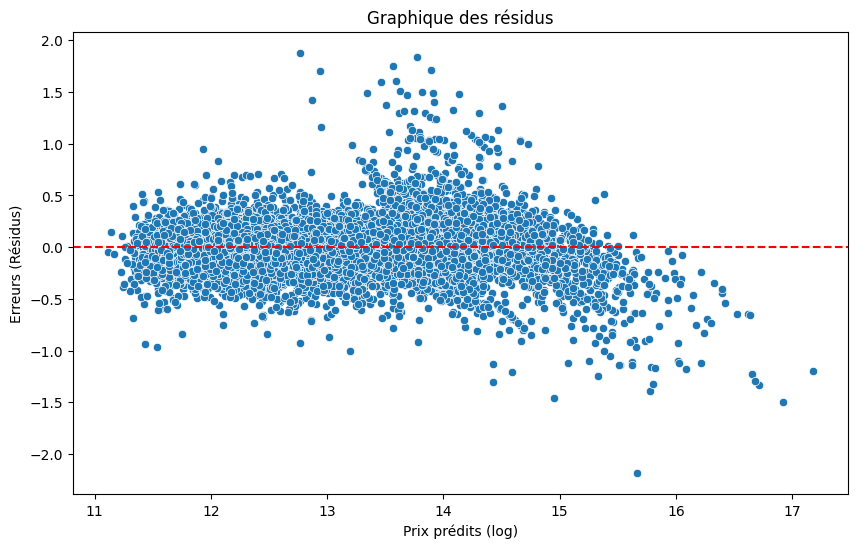

In [15]:
y_train_pred = cross_val_predict(lr, X_train_scaled, y_train, cv=5)

# Prédiction .flatten() force le format 1D
y_train_flat = y_train.values.flatten()

# Calcul les résidus  
residuals = y_train_flat - y_train_pred.flatten()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train_pred.ravel(), y=residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Ligne horizontale à 0
plt.title('Graphique des résidus')
plt.xlabel('Prix prédits (log)')
plt.ylabel('Erreurs (Résidus)')
plt.show()

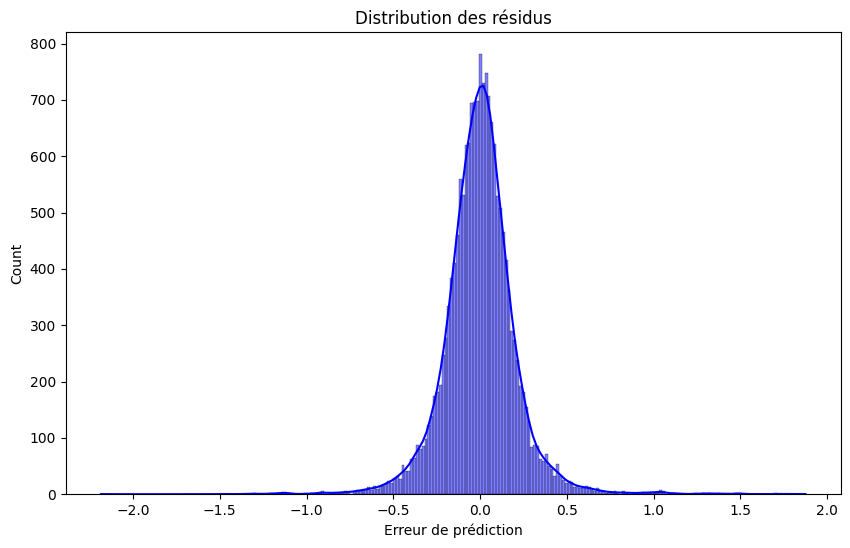

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Distribution des résidus')
plt.xlabel('Erreur de prédiction')
plt.show()

In [17]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled, y_train)
rf.score(X_train_scaled, y_train)

0.9993782062976915

Détection d'over fitting avec validation_curve

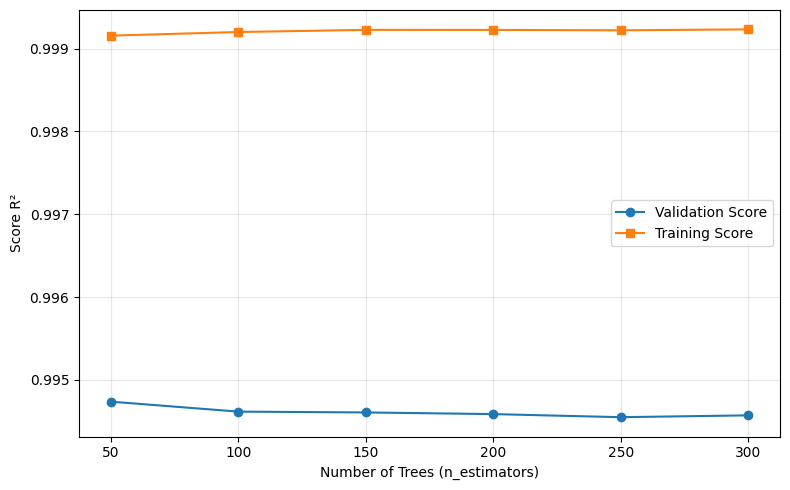

In [18]:
param_range = np.arange(50, 301, 50)

plt.figure(figsize=(8, 5))

train_score, val_score = validation_curve(
    estimator=rf,
    X=X_train_scaled,
    y=y_train,
    param_name="n_estimators",
    param_range=param_range,
    cv=3,
    scoring="r2",
    n_jobs=-1,
)

plt.plot(param_range, val_score.mean(axis=1), marker="o", label="Validation Score")
plt.plot(param_range, train_score.mean(axis=1), marker="s", label="Training Score")
plt.ylabel("Score R²")
plt.xlabel("Number of Trees (n_estimators)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Analyse :
On observe un plateau rapide dès 50-100 arbres.<br>
L'écart constant entre le score d'entraînement (proche de 1.0) et le score de validation indique un modèle complexe qui tend à mémoriser les données (overfitting).<br>
Augmenter le nombre d'arbres au-delà de 100 n'améliore pas la généralisation<br> mais augmente le coût de calcul.

In [21]:
# Initialisation des modèles
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.001, max_iter=5000),
    #  limite max_depth pour le RF pour tenter de réduire l'overfitting constaté
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
}

# Configuration de la validation croisée
cv = KFold(n_splits=5, shuffle=True, random_state=42)
rows = []
rf_model = None  # Variable pour garder le modèle RandomForest

# Définition des métriques à calculer en CV
scoring_metrics = {'r2': 'r2', 'mae': 'neg_mean_absolute_error'}

for name, mdl in models.items():
    # 1. Calcul des scores en Cross-Validation (plus efficace avec cross_validate)
    cv_results = cross_validate(mdl, X_train_scaled, y_train, cv=cv, scoring=scoring_metrics)
    cv_r2 = cv_results['test_r2'].mean()
    cv_mae = -cv_results['test_mae'].mean() # On repasse en positif
    
    # 2. Entraînement final sur tout le set de train et test sur le set de test
    mdl.fit(X_train_scaled, y_train)

    y_pred_test = mdl.predict(X_test_scaled)
    r2_test = mdl.score(X_test_scaled, y_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)

# Conservation du modèle RandomForest
    if name == 'RandomForest':
        rf_model = mdl
    
    rows.append({
        'model': name,
        'cv_r2': cv_r2,
        'cv_mae': cv_mae,
        'test_r2': r2_test,
        'test_mae': mae_test
    })

# Création et affichage du tableau de résultats
results_df = pd.DataFrame(rows).sort_values(by=['cv_r2'], ascending=False)
results_df

,model,cv_r2,cv_mae,test_r2,test_mae
3,RandomForest,0.994803,0.010094,0.897526,0.087788
0,LinearRegression,0.946131,0.147054,0.947969,0.144433
1,Ridge,0.946131,0.146744,0.947931,0.144286
2,Lasso,0.937087,0.155079,0.938388,0.154629


#### Analyse :
**RandomForest** affiche le meilleur score en validation croisée ($R^2 \approx 0.99$)<br>
mais sa performance chute significativement sur le jeu de test ($R^2 \approx 0.89$)<br>
confirmant un manque de robustesse.

À l'inverse, la **Régression Linéaire** et **Ridge** présentent des scores très stables ($R^2 \approx 0.94$ en CV et en Test)<br>
démontrant une excellente capacité à prédire sur des données inconnues.

### Conclusion :
Malgré la puissance théorique du RandomForest, les modèles linéaires (Linear/Ridge) s'avèrent être les plus performants pour ce cas d'usage précis.

##### Points clés retenus :
**Simplicité vs Complexité :** La relation entre les variables semble majoritairement linéaire<br>
rendant les modèles simples plus efficaces et moins sujets au sur-apprentissage.


#### Choix final :
Je préconise l'utilisation du modèle **Ridge**<br>
Il offre un excellent compromis entre précision ($R^2 = 0.947$) et stabilité<br>
tout en étant plus léger et interprétable pour une mise en production.

#### Perspectives :
Pour surpasser le modèle linéaire, une optimisation fine des hyperparamètres de régularisation du RandomForest (max_depth, min_samples_leaf) ou l'utilisation d'un modèle de Gradient Boosting (XGBoost/LGBM) pourrait être envisagée dans une prochaine itération.


In [25]:
# Créer le dossier models s'il n'existe pas
if not os.path.exists("models"):
    os.makedirs("models")

# # ==========  Sauvegarder le modèle RandomForest =======
with open("models/random_forest_model.pkl", "wb") as f:
    pickle.dump(rf_model, f)

print("✅ Modèle RandomForest sauvegardé : models/random_forest_model.pkl")




# ========   Extraction du modèle Ridge depuis le dictionnaire models ========
ridge_model = models['Ridge']

# Sauvegarde du modèle Ridge
model_path = "models/ridge_model.pkl"
with open(model_path, "wb") as f:
    pickle.dump(ridge_model, f)

print(f"✅ Modèle Ridge sauvegardé : {model_path}")



# ========= Preprocessor complet (Pipeline + ColumnTransformer) =========
# Contient Imputers, StandardScaler et OneHotEncoder
with open("models/preprocessor.pkl", "wb") as f:
    pickle.dump(preprocessor, f) 

print("✅ Pipeline de production sauvegardé :")
print("   - Modèle : models/ridge_model.pkl")
print("   - Préprocesseur : models/preprocessor.pkl")

✅ Modèle RandomForest sauvegardé : models/random_forest_model.pkl
✅ Modèle Ridge sauvegardé : models/ridge_model.pkl
✅ Pipeline de production sauvegardé :
   - Modèle : models/ridge_model.pkl
   - Préprocesseur : models/preprocessor.pkl
